<a href="https://colab.research.google.com/github/awesome786engineer/Machine-Learning-Projects/blob/main/InstaFakeID_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from huggingface_hub import login
login()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [ ]:
from datasets import load_dataset
dataset = load_dataset("nahiar/instagram_bot_detection")

In [4]:
df = dataset['train'].to_pandas()
df.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


In [5]:
df.shape

(5000, 12)

In [6]:
# shuffle the DF before applying train test split
df_shuffled = df.sample(frac = 1, random_state = 42).reset_index(drop = True)

splitting_point = int(0.8*len(df))
train_df = df_shuffled.iloc[:splitting_point]
test_df = df_shuffled.iloc[splitting_point:]

In [7]:
train_df = train_df.sample(frac = 1,random_state = 42).reset_index(drop = True)
test_df = test_df.sample(frac = 1,random_state = 42).reset_index(drop = True )

In [8]:
train_df.head()


,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.000000,1,0.0,0,25,0,0,299,4845,696,0
1,1,0.036261,2,0.0,0,21,0,0,389,754,406,0
2,0,0.617325,1,0.0,0,0,0,0,0,85,31,1
3,1,0.060000,2,0.0,0,11,0,1,19,417,395,0
4,1,0.000000,0,0.0,0,14,0,0,10,291,371,0


In [9]:
test_df.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,0,0.281669,0,0.000000,0,0,0,0,5,1081,547,1
1,1,0.083349,1,0.062512,0,43,0,0,11,18,42,1
2,0,0.738726,1,0.839461,0,0,0,0,4,53,67,1
3,1,0.000000,2,0.000000,0,4,0,0,11,194,211,0
4,1,0.000000,2,0.000000,0,21,0,0,110,417,279,0


In [10]:
len(train_df),len(test_df)

(4000, 1000)

Here "nums/length" and nums/length_full_name" is ratio of numerical characters in its user name and its full name

## MLWorkFLow ##

1. Data preprocessing used

    -  missing numerical values were replaced by mediian values reducing effect of  outliers
    -  missing categorical values(eg profile picture ) were replaced with mode  
2. Data transformation

    - apply one hot encoding for features "profile pic","private","external URL", presence = 1, absence = 0

3. Outlier Detection and Removal
    
    - use interquartile range or z- score method to detect and remove outlier that might skew the model performance

4. Feature selection

    - to avoid multicollinearity using "CORRELATION MATRIX"
    - lasso (L1) regularization to select importnat features by shrinking the less important features coefficients to zero
    - use RECURSIVE FEATURE ELEMINATION to select top performin features by iteratively training and eliminating weaker features

5. Normalization

    - normalize high performing features

6. Model building using
    - for now logistic regression only
    - later implement 1. KNN ,2. Random Forest,3. SVC(support vector classifier)




# OUTLIER DETECTION AND REMOVAL #

In [11]:
# plot the distribution of all numeric features
binary_columns = ["profile pic","name==username","external URL","private","fake"]
non_binary_columns = [col for col in train_df.columns if col not in binary_columns]

In [12]:
len(non_binary_columns)

7

In [13]:
non_binary_columns

['nums/length username',
 'fullname words',
 'nums/length fullname',
 'description length',
 '#posts',
 '#followers',
 '#follows']

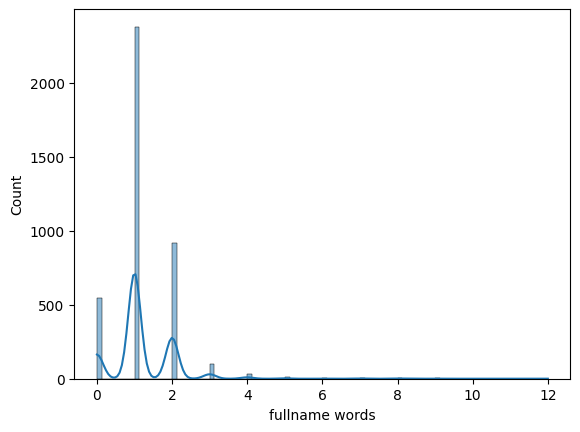

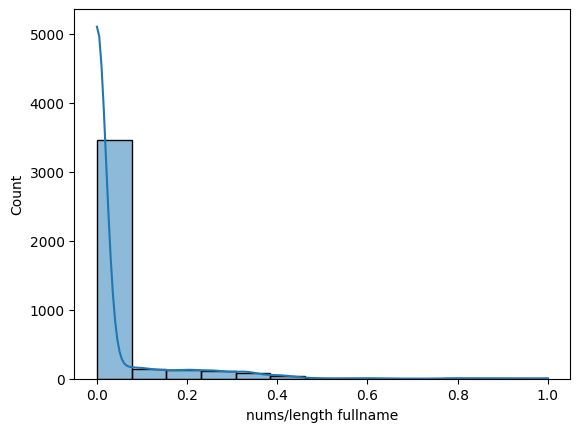

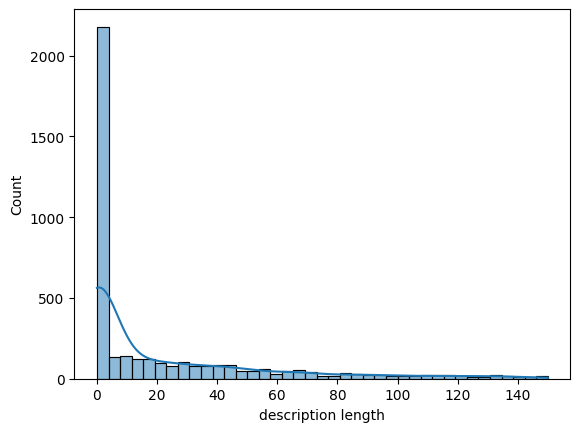

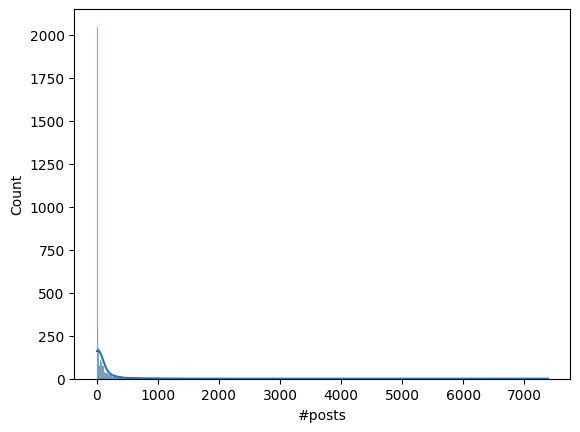

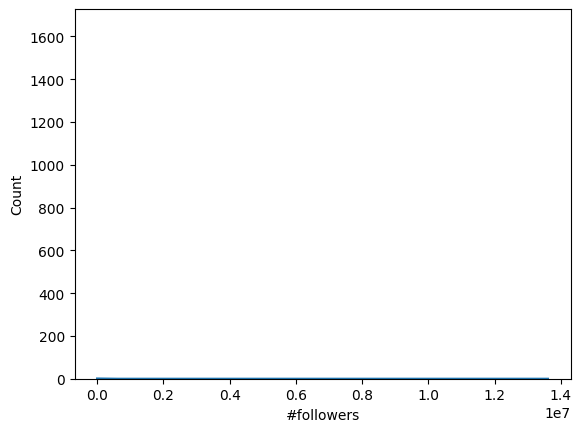

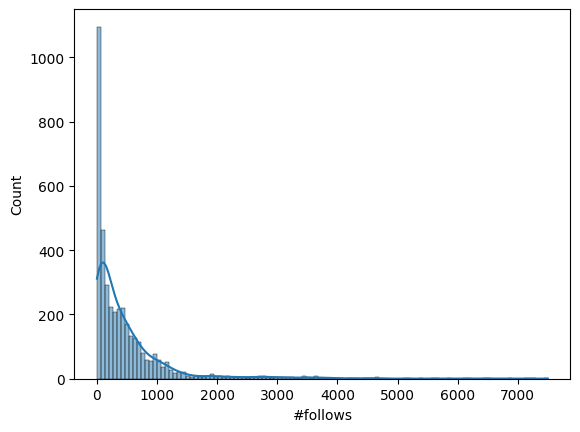

In [15]:
for col in non_binary_columns[1:]:
  sns.histplot(data = train_df,x = col,kde = True)
  plt.show()

In [ ]:
# for i in range(5):
#   sns.histplot(data = train_df,x = non_binary_columns[i],kde = True)
#   plt.show()

In [ ]:
# calculating skewness of all the attributes
train_df[non_binary_columns].skew()

In [ ]:
train_df.corr()

In [ ]:
selected_columns = ['profile pic','nums/length username','fullname words','description length','external URL']

# Applying IQR range for Outlier Detection #

In [ ]:
# making box plot for all the non_binary columns
# for col in non_binary_columns:
#   train_df.boxplot(column = col)
#   plt.show()

## capping the outliers #

In [ ]:
new_train_df = train_df.copy()
new_test_df = test_df.copy()

In [ ]:
def filter_iqr(original_df,col,new_df,train = True):
  Q1 = original_df[col].quantile(0.25)
  Q3 = original_df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_limit = Q1 - 1.5 * IQR
  upper_limit = Q3 + 1.5 * IQR
  if train:
    new_df[col] = original_df[col].clip(lower = lower_limit ,upper = upper_limit)
  else:
    new_df[col] = test_df[col].clip(lower = lower_limit ,upper = upper_limit)
  return (lower_limit,upper_limit)


In [ ]:
from collections import defaultdict
quartile_limits = defaultdict(tuple)
for col in non_binary_columns:
  quartile_limits[col] = filter_iqr(train_df,col,new_train_df)
  filter_iqr(train_df,col,new_test_df,train = False)

In [ ]:
for col in selected_columns:
  print(col + " : " + str(quartile_limits[col]))

In [ ]:
new_train_df[non_binary_columns].skew()

In [ ]:
new_test_df[non_binary_columns].skew()

# Applying Logistic regression on IQR filtered data #

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
X_train = new_train_df.drop('fake',axis = 1)
y_train = new_train_df['fake']
X_test = new_test_df.drop('fake',axis = 1)
y_test = new_test_df['fake']


# Logistic regression without sklearn #

In [ ]:
def sigmoid(z):
  return 1/(1 + np.exp(-z))

In [ ]:
def compute_cost_vectorized(X, w, b, y):
  m = X.shape[0]
  z = X @ w + b  # (m,n) @ (n,) -> (m,). Vectorized dot product for all examples!
  f_wb = sigmoid(z) # (m,) vector of all predictions

  # Element-wise operations on the entire vectors
  cost = -y * np.log(f_wb) - (1 - y) * np.log(1 - f_wb)
  total_cost = np.sum(cost) / m

  return total_cost


In [ ]:
def gradient_functions_vectorized(X, w, b, y):
  m, n = X.shape
  z = X @ w + b      # (m,) vector of z for all examples
  f_wb = sigmoid(z)  # (m,) vector of all predictions

  error = f_wb - y   # (m,) vector of all errors

  # (m,) * (m, n) is not what we want. We need (n,) result.
  # So we do (n, m) @ (m,) -> (n,)
  dj_dw = (X.T @ error) / m # transpose of X(m,n) is X.T(n,m)
  dj_db = np.sum(error) / m

  return dj_dw, dj_db

In [ ]:
def train_vectorized(X, y, alpha, num_iters):
  cost_history =[]
  w = np.zeros(X.shape[1])
  b = 0
  for i in range(num_iters):
    dj_dw, dj_db = gradient_functions_vectorized(X, w, b, y)
    w = w - alpha * dj_dw
    b = b - alpha * dj_db

    if i % 1000 == 0: # Check cost less frequently to save time
        cost = compute_cost_vectorized(X, w, b, y)
        cost_history.append(cost)
        print(f"Iteration {i:5d}: Cost {cost:0.4f}")

  return w, b, cost_history


In [ ]:
def predict_vectorized(X, w, b):
  z = X @ w + b
  f_wb = sigmoid(z)
  p = f_wb >= 0.5 # Creates a boolean array
  return p.astype(int)

In [ ]:
#w, b,cost_history = train(X_train[selected_columns].values,y_train,0.01,15000)

In [ ]:
w, b,cost_history = train_vectorized(X_train[selected_columns].values,y_train,0.01,15000)

In [ ]:
y_pred = predict_vectorized(X_test[selected_columns].values,w,b)

In [ ]:
accuracy_score(y_test,y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(cost_history)),  # X-axis: iteration numbers (0 to 9999)
    cost_history,              # Y-axis: cost values
    color='blue',
    linestyle='solid',
    linewidth=2
)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost', fontsize=12)
plt.title('Learning Curve (Cost vs. Iterations)', fontsize=14)
plt.show()


In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
w,b

In [ ]:
# testing on real account
w = np.array([-2.80260132,  3.60909299, -0.35848741, -0.02805083, -1.33505898])
b = 2.659345278516536

In [ ]:
for col in selected_columns:
  print(col + " : " + str(quartile_limits[col]))